In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import optuna
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

sys.path.append(os.path.abspath(os.path.join('..', '..\\models')))
from NODE import NODE
from SAINT import SAINT
from TabTransformers import TabularTransformer

# Data Loading

In [4]:
df_train = pd.read_csv('..\\..\\datasets\\predict-failure-keep-it-dry.csv')

In [5]:
# separate the label/class
label = df_train.pop('failure')

In [6]:
df_train.head(10)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885
5,5,A,75.35,material_7,material_8,9,5,11,4,0,...,20.810,10.622,14.904,19.107,13.327,15.354,19.251,NaN,17.625,832.902
6,6,A,161.71,material_7,material_8,9,5,12,2,4,...,17.916,11.370,17.714,19.924,11.560,16.653,17.734,NaN,16.637,684.438
7,7,A,177.92,material_7,material_8,9,5,4,8,8,...,18.643,10.254,16.449,20.478,12.207,15.624,16.968,15.176,17.231,684.000
8,8,A,109.50,material_7,material_8,9,5,9,6,5,...,19.887,11.557,15.965,19.604,14.091,15.674,13.327,13.535,15.408,NaN
9,9,A,98.72,material_7,material_8,9,5,10,4,7,...,19.011,10.384,15.237,18.427,12.635,14.318,14.327,12.867,NaN,NaN


In [7]:
df_train.shape

(26570, 25)

In [8]:
num_cols = ['loading', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']
cat_cols = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']

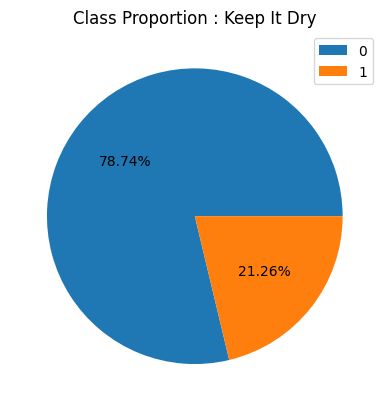

In [9]:
# Count frequency each class
category_counts = label.value_counts()
size = label.value_counts()

# Create Bar Chart
plt.pie(size, autopct="%.2f%%")
plt.legend(labels=category_counts.index)
plt.title('Class Proportion : Keep It Dry')
plt.show()

# Preprocessing

In [10]:
def prepo(df):
    df_processed = df.copy()
    
    # Drop the "material_" word
    df_processed['attribute_0'] = df_processed['attribute_0'].str.replace('material_', '').astype(int)
    df_processed['attribute_1'] = df_processed['attribute_1'].str.replace('material_', '').astype(int)

    # Dropping the Non-informative Feature
    df_processed = df_processed.drop(columns=['id', 'product_code'])

    # Define Pipeline & Column Transformer
    num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # best method so far on this dataset
    ('scaler', StandardScaler()) # for speed up the runtime
    ])

    column_transformer = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, num_cols),
            ('cat', SimpleImputer(strategy='mean'), cat_cols)
        ]
    )

    # Fit and transform data
    df_processed = column_transformer.fit_transform(df_processed)

    # split data into feature & target
    X = df_processed
    y = label

    # split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # change the scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # change to array
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_test, y_train, y_test = prepo(df_train)

In [12]:
# Determine the input and output dimensions
X_dim = X_train.shape[1]
y_dim = label.nunique()

# Modelling

In [13]:
# Dataframe for evaluation result each model
eval_columns = ['Model', 'Accuracy', 'F1', 'ROC AUC', 'Execution Time']
eval_results = pd.DataFrame(columns=eval_columns)
eval_results

,Model,Accuracy,F1,ROC AUC,Execution Time


In [18]:
input_dim = X_dim
output_dim = y_dim

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

## Train & Eval Function

In [17]:
def train_eval(model, model_name, X_train, X_test, y_train, y_test):
    # Define start time recording
    start_time = time.time()
    if not isinstance(model, TabNetClassifier):
        model.fit(X_train, y_train)
    else : 
        model.fit(X_train=X_train, 
                y_train=y_train, 
                eval_set=[(X_test, y_test)],
                eval_metric=['accuracy', 'auc'],
                max_epochs=100, 
                patience=10,
                batch_size=256,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False)
    # Predict
    y_pred = model.predict(X_test)
    # Eval
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1:.4f}")
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':accuracy, 'F1':f1, 'ROC AUC':roc_auc, 'Execution Time':execution_time}])

    return result

## Deep Learning

### NODE : Neural Oblivious Decision Ensembles

In [19]:
NODE_model = NODE(input_dim, output_dim, num_trees=10, tree_depth=6, hidden_dim=128)

In [20]:
result = train_eval(NODE_model, "NODE Classifier", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

AUC-ROC calculation skipped for batch with only one class
Epoch [10/100], Loss: 0.4940, Avg Batch AUC-ROC: 0.6466
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [20/100], Loss: 0.4165, Avg Batch AUC-ROC: 0.7811
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [30/100], Loss: 0.3133, Avg Batch AUC-ROC: 0.8524
AUC-ROC calculation skipped for batch with only one class
Epoch [40/100], Loss: 0.2357, Avg Batch AUC-ROC: 0.8845
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [50/100], Loss: 0.2070, Avg Batch AUC-ROC: 0.8882
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [60/100], Loss: 0.

C:\Users\fadhil\AppData\Local\Temp\ipykernel_10184\1212388360.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_results = pd.concat([result, eval_results], ignore_index=True)


### Tab-Transformer

In [48]:
# Define Tab-Transfomer Model
TabTR_model = TabularTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_size=32,
    num_heads=4,
    forward_expansion=128,
    dropout=0.1
)

In [49]:
result = train_eval(TabTR_model, "Tab-Transformer", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.5087, Avg Batch AUC-ROC: 0.5968
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [20/100], Loss: 0.5055, Avg Batch AUC-ROC: 0.6087
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [30/100], Loss: 0.5037, Avg Batch AUC-ROC: 0.6139
Epoch [40/100], Loss: 0.4988, Avg Batch AUC-ROC: 0.6339
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [50/100], Loss: 0.4911, Avg Batch AUC-ROC: 0.6543
Epoch [60/100], Loss: 0.4907, Avg Batch AUC-ROC: 0.6585
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [70/100], Loss: 0.4823, Avg Batch AUC-ROC: 0.6821
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped 

### TabNet

In [50]:
# Define TabNet Model
TabNet_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         scheduler_params=dict(step_size=10, gamma=0.9),
                         mask_type='sparsemax')

result = train_eval(TabNet_model, "Tabnet", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55543 | val_0_accuracy: 0.78735 | val_0_auc: 0.52068 |  0:00:02s
epoch 1  | loss: 0.51661 | val_0_accuracy: 0.78754 | val_0_auc: 0.561   |  0:00:04s
epoch 2  | loss: 0.51512 | val_0_accuracy: 0.78735 | val_0_auc: 0.56659 |  0:00:07s
epoch 3  | loss: 0.51601 | val_0_accuracy: 0.78735 | val_0_auc: 0.56472 |  0:00:09s
epoch 4  | loss: 0.5135  | val_0_accuracy: 0.78735 | val_0_auc: 0.57902 |  0:00:11s
epoch 5  | loss: 0.51189 | val_0_accuracy: 0.78735 | val_0_auc: 0.57787 |  0:00:14s
epoch 6  | loss: 0.51256 | val_0_accuracy: 0.78735 | val_0_auc: 0.57577 |  0:00:17s
epoch 7  | loss: 0.51156 | val_0_accuracy: 0.78735 | val_0_auc: 0.58253 |  0:00:19s
epoch 8  | loss: 0.51163 | val_0_accuracy: 0.78735 | val_0_auc: 0.57931 |  0:00:21s
epoch 9  | loss: 0.51149 | val_0_accuracy: 0.78735 | val_0_auc: 0.57449 |  0:00:24s
epoch 10 | loss: 0.51226 | val_0_accuracy: 0.78735 | val_0_auc: 0.572   |  0:00:26s
epoch 11 | loss: 0.51173 | val_0_accuracy: 0.78735 | val_0_auc: 0.57378 |  0

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.7874
F1: 0.6937
ROC AUC: 0.5825


### SAINT

In [57]:
SAINT_model = SAINT(
    input_dim = X_dim,
    output_dim = y_dim,
    attn_dim = 16,
    num_heads = 2,
    num_layers = 3,
    hidden_dim = 64
)

In [58]:
result = train_eval(SAINT_model, "SAINT", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

AUC-ROC calculation skipped for batch with only one class
Epoch [10/100], Loss: 0.5121, Avg Batch AUC-ROC: 0.5907
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [20/100], Loss: 0.5083, Avg Batch AUC-ROC: 0.6089
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [30/100], Loss: 0.5050, Avg Batch AUC-ROC: 0.6192
Epoch [40/100], Loss: 0.5022, Avg Batch AUC-ROC: 0.6298
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
AUC-ROC calculation skipped for batch with only one class
Epoch [50/100], Loss: 0.4960, Avg Batch AUC-ROC: 0.6393
AUC-ROC calculation skipped for batch with only one class
Epoch [60/100], Loss: 0.4957, Avg Batch AUC-ROC: 0.6537
AUC-ROC calculation skipped for batch with only one class
Epoch [70/100], Loss: 0.4934, Avg Batch AUC-ROC: 0.6584
AUC-ROC calculation skipped 

## Machine Learning

### Random Forest

In [51]:
# Define Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Train & Eval with function
result = train_eval(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.7872
F1: 0.6939
ROC AUC: 0.5415


### XGBoost

In [52]:
# Define XGBoost Model
xgb_model = XGBClassifier(random_state=42)

# Train & Eval with function
result = train_eval(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.7717
F1: 0.7005
ROC AUC: 0.5366


### LightGBM

In [53]:
# Define LightGBM Model
lgbm_model = LGBMClassifier(random_state=42)

# Train & Eval with function
result = train_eval(lgbm_model, "LightGBM", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

[LightGBM] [Info] Number of positive: 4519, number of negative: 16737
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4180
[LightGBM] [Info] Number of data points in the train set: 21256, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212599 -> initscore=-1.309331
[LightGBM] [Info] Start training from score -1.309331
Accuracy: 0.7862
F1: 0.6945
ROC AUC: 0.5503


### CatBoost

In [54]:
# Define CatBoost Model
cb_model = CatBoostClassifier(random_state=42)

# Train & Eval with function
result = train_eval(cb_model, "CatBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Learning rate set to 0.037999
0:	learn: 0.6783259	total: 31.5ms	remaining: 31.4s
1:	learn: 0.6653569	total: 40.8ms	remaining: 20.4s
2:	learn: 0.6534001	total: 48.8ms	remaining: 16.2s
3:	learn: 0.6418791	total: 55.2ms	remaining: 13.7s
4:	learn: 0.6317432	total: 61.7ms	remaining: 12.3s
5:	learn: 0.6224813	total: 68.6ms	remaining: 11.4s
6:	learn: 0.6133877	total: 75.2ms	remaining: 10.7s
7:	learn: 0.6051032	total: 81.8ms	remaining: 10.1s
8:	learn: 0.5974258	total: 88ms	remaining: 9.69s
9:	learn: 0.5903609	total: 94.5ms	remaining: 9.36s
10:	learn: 0.5838927	total: 101ms	remaining: 9.07s
11:	learn: 0.5780067	total: 107ms	remaining: 8.83s
12:	learn: 0.5726147	total: 114ms	remaining: 8.64s
13:	learn: 0.5674656	total: 121ms	remaining: 8.49s
14:	learn: 0.5627534	total: 127ms	remaining: 8.31s
15:	learn: 0.5583541	total: 133ms	remaining: 8.16s
16:	learn: 0.5544361	total: 139ms	remaining: 8.02s
17:	learn: 0.5510371	total: 145ms	remaining: 7.91s
18:	learn: 0.5476335	total: 151ms	remaining: 7.77s
19:

# Evaluation

In [ ]:
eval_results

In [62]:
# eval_results.to_excel('KeepItDry_Eval_Results.xlsx', index=False)